In [1]:
import matplotlib.pyplot as plt
import numpy as np

from math import *
from scipy.optimize import curve_fit, minimize
from scipy.stats import poisson
from tqdm import tqdm
from glob import glob

from matplotlib.ticker import FormatStrFormatter

In [2]:
countrateData = np.loadtxt("./../data/countRate_vs_threshold.txt", delimiter=",", skiprows=1)

countrateDictionary = {
    "threshold": countrateData[:,0],
    "counts": countrateData[:,1],
    "time": countrateData[:,2]
}

rates = []
for count, time in zip (countrateDictionary["counts"], countrateDictionary["time"]):
    rates.append(count / time)

countrateDictionary["rates"] = rates

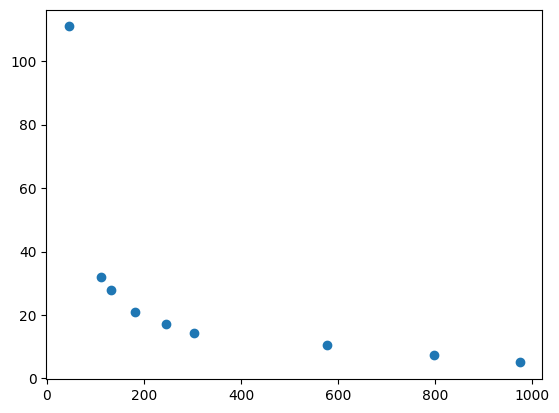

In [3]:
plt.scatter(countrateDictionary["threshold"], countrateDictionary["rates"])

# Loading Data
This section comprises the loading of data runs. The data is saved in sections of 1.2 hours and so a second function was created to load multiple files together.

## Calibration

In [4]:
channels = [73, 152, 234, 316, 395, 593, 807]
lifetimes_ns = [100, 200, 300, 400, 500, 750, 1000]

lifetimes_us = [el * 10e-3 for el in lifetimes_ns]

def Linear(x, m, c):
    return m*x + c

calib_pars, calib_cov = curve_fit(Linear, channels, lifetimes_us)

print(calib_pars)

[0.01230729 0.12432428]


In [5]:
def ApplyCalibration(channelNumbers):
    lifetimes = []
    for channel in channelNumbers:
        lifetimes.append(0.012 * channel + 0.124)

    return lifetimes

In [6]:
def LoadExperimentRun(path, numberOfChannelsToRemove, calibrate=False):

    channelCounts = np.loadtxt(path)[numberOfChannelsToRemove[0]:-numberOfChannelsToRemove[1]]

    channelNumbers = np.arange(numberOfChannelsToRemove[0], len(channelCounts))

    if calibrate is True:
        channelNumbers = ApplyCalibration(channelNumbers)

    return (channelNumbers, channelCounts)

def LoadMultipleRuns(basePath, filenamePrefix, numberOfChannelsToRemove, calibrate=False):
    #print(basePath + filenamePrefix + "*.txt")
    filePaths = glob(basePath + filenamePrefix + "*.txt")
    
    filePaths.sort()
    print(f"Loading:\n{filePaths}")

    binsSample = LoadExperimentRun(filePaths[0], numberOfChannelsToRemove, calibrate)[0]
    countsSample = LoadExperimentRun(filePaths[0], numberOfChannelsToRemove)[1]

    binCounts = np.zeros(np.shape(countsSample))
    for filePath in filePaths:
        binCounts = binCounts + LoadExperimentRun(filePath, numberOfChannelsToRemove, calibrate)[1]

    occurances = 0
    for el in binCounts:
        occurances += el


    print(f"{occurances} occurances")
        
    return (binsSample, binCounts)

# Data Analysis Pipeline
## Re-Binning Data

In [7]:
def RebinData(data, binFraction, method="mean", verbose=False):
    # Inputs are the data output from LoadExperimentRun, and a binFraction which is a number between 0 and 1 which determines how large the bins are

    bins = list(data[0])
    data = list(data[1])

    binWidth = (bins[-1] - bins[0]) * binFraction

    lowerBound = bins[0]
    numberOfBins = floor((bins[-1] - bins[0]) / binWidth)

    newBins = np.arange(lowerBound, binWidth * (numberOfBins + 1), binWidth)
    newBins = [floor(el) for el in newBins]

    #topBound = floor(newBins[-1] + binWidth)
    #newBins.append(topBound)
    
    binnedData = []

    for i, binBound in enumerate(newBins):
        #print(f"{i}/{len(newBins)}")
        if i < len(newBins)-1:
            binnedData.append(list(data[newBins[i]:newBins[i+1]]))

    # binnedData is a an array which each row containing a bin
    binnedData = np.array(binnedData, dtype="object")

    averagedBinnedData = []
    binnedDataLowerUncertainty = []
    binnedDataUpperUncertainty = []
    for row in tqdm(binnedData, disable= not verbose):

        avg = AverageDataInBin(row, method, verbose=verbose)
        averagedBinnedData.append(avg[0])
        binnedDataLowerUncertainty.append(avg[1])
        binnedDataUpperUncertainty.append(avg[2])

    return (newBins[:-1], averagedBinnedData, binnedDataLowerUncertainty, binnedDataUpperUncertainty)
    


In [9]:
data = LoadMultipleRuns("../data/", "autoDetection_T-800mV_40ns_DMH_", (90, 200), calibrate=True)

Loading:
['../data/autoDetection_T-800mV_40ns_DMH_4320s_001.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_002.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_003.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_004.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_005.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_006.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_007.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_008.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_009.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_010.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_011.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_012.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_013.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_014.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_015.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_016.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_017.txt', '../data/autoDetection_T-800mV_40ns_DM

## Methods for Averaging Data

In [21]:
def AverageDataInBin(dataInBin, method="mean", verbose=False):

    if method == "mean":
        averagedRow = sum(dataInBin) / len(dataInBin)
        uncertainty = np.std(dataInBin)

        upperUncertainty = lowerUncertainty = uncertainty / np.sqrt(len(dataInBin))
        

    elif method == "gaussian":
        averagedRow = np.mean(dataInBin)
        variance = np.sqrt(averagedRow)
        standardError = variance / np.sqrt(len(dataInBin))

        upperUncertainty = lowerUncertainty = standardError

    elif method == "MLE":
        
        # Finds the maximum likelihood for mu in a poisson distribution
        # To do this we can find the minimum of the negative log likelihood
        model = minimize(MLE_negativeLogLikelihood, np.max(dataInBin) / 2, args=dataInBin, method="Nelder-Mead")
        
        averagedRow = model.x
        lowerUncertainty, upperUncertainty = poisson.interval(0.68, averagedRow) # 1 sigma uncertainty
        lowerUncertainty, upperUncertainty = (lowerUncertainty / np.sqrt(len(dataInBin)), upperUncertainty / np.sqrt(len(dataInBin)))
        
        if verbose:
            print(averagedRow, uncertainty)

    return averagedRow, lowerUncertainty, upperUncertainty


# Method of Maximum Likelihood Estimation - Calculate the likelihood of the pmf function of a given mu for each datapoint in the bin
def MLE_negativeLogLikelihood(lamda, data):

    logLikelihoods = []
    for el in data:
        logLikelihoods.append(poisson.pmf(k=el, mu = lamda))

    return -1 * np.sum(logLikelihoods)


def FindFitParameters(data, FittingFunction, sigma, initialPars=None):

    if sigma != None:
        pars, cov = curve_fit(FittingFunction, data[0], data[1], initialPars, sigma=sigma, absolute_sigma=True, check_finite=True)

    else:
        pars, cov = curve_fit(FittingFunction, data[0], data[1], initialPars)

    return pars, cov
    
def ExponentialCurve(x, a, b, c, d):
    y = []
    
    for point in x:
        y.append(a * exp(b * point + c) + d)
    
    return y

#, [10, -0.01, 0.1, 15]

## Find Best Bin Size
This section handles the plotting of the uncertainties on the parameters of a least squares fit for **any input function**. This plot can be used to estimate the most optimal bin-size.

In [22]:
def FindOptimumBinFraction(data, binFractions, FitFunction=ExponentialCurve, method="gaussian", initialPars=None):

    parameterUncertainties = []

    print("Assessing bin fractions")
    for binFrac in binFractions:
        #print(f"Testing binFrac: {binFrac}", end="\r")
        rebinnedData = RebinData(data, binFrac, method=method)

        x = rebinnedData[0]
        y = rebinnedData[1]
        y = np.squeeze(y)

        tol = 0.1
        newSigma = []
        for el in rebinnedData[2]:
            if el < tol:
                newSigma.append(tol)
            else:
                newSigma.append(el)

        pars, cov = FindFitParameters((x,y), FitFunction, sigma=None, initialPars=initialPars)

        for i in range(len(cov)):
            parameterUncertainties.append(np.sqrt(cov[i][i]))

    # Normalise and make array of uncertainties

    parameterUncertainties = np.array(parameterUncertainties).reshape(len(binFractions), len(cov))

    #for i, uncertainties in enumerate(parameterUncertainties.T):
        
        #parameterUncertainties[:,i] = [el / max(uncertainties) for el in uncertainties]
    
    return (binFractions, parameterUncertainties)

# Analysis

## Finding optimum bin sizes

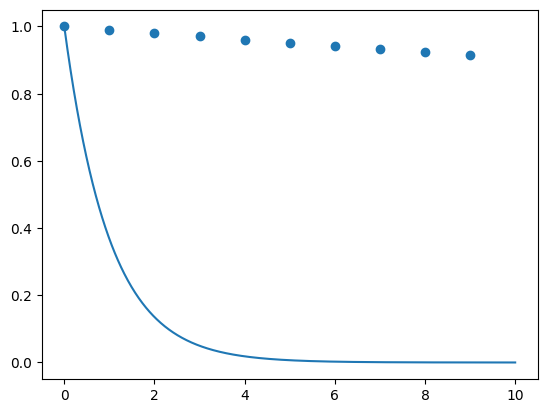

In [39]:
fakeDataX = np.linspace(0, 10, 1000)
fakeDataY = ExponentialCurve(fakeDataX, 1, -1, 0, 0)

plt.plot(fakeDataX, fakeDataY)

rebinnedFakeData = RebinData((fakeDataX, fakeDataY), binFraction=0.1, method="gaussian")

plt.scatter(rebinnedFakeData[0], rebinnedFakeData[1])

In [32]:
data = (fakeDataX, fakeDataY)

binFractions = np.linspace(0.01, 0.2, 1000)

_, parameterUncertainties = FindOptimumBinFraction(data, binFractions, initialPars=[1, -1, 0, 0])

fig, axes = plt.subplots(4, 1, figsize=(6,8), sharex=True)

fig.text(0.01, 0.5, 'Fit Parameter Normalised Uncertainty', va='center', rotation='vertical')

parameterNames = ["a", "b", "c", "d"]
yLimits = [0.1, 0.3, 0.1, 0.5]

for ax, uncertainties, parameterName, yLim in zip(axes, parameterUncertainties.T, parameterNames, yLimits):

    uncertainties = np.array(uncertainties)

    uncertainties[uncertainties == inf] = np.nan

    uncertainties = uncertainties / max(uncertainties)

    ax.plot(binFractions, uncertainties, color="indianred")

    ax.margins(0)
    ax.set_ylabel(parameterName, rotation=0)
    ax.set_ylim(0, yLim)

    ax.axvline(x=0.022,ymin=0,ymax=1,c="mediumturquoise", linestyle="dashed", clip_on=False, label="Chosen Bin Fraction")

    if ax == axes[-1]:
        ax.set_xlabel("Bin Size (fraction of total number of ch.)")

    if ax == axes[0]:
        ax.set_title("Fit parameter uncertainties for: $f(x) = a e^{(b x + c)} + d$")
        ax.legend()



Assessing bin fractions


ValueError: array must not contain infs or NaNs

## Gaussian Approximation of the Poisson Distribution

In [297]:
#data = LoadExperimentRun("./../data/autoDetection_T-800mV_40ns_DMH_75600s_000.txt", 90)

data = LoadMultipleRuns("../data/", "autoDetection_T-800mV_40ns_DMH_", (90, 20), calibrate=True)

binFraction = 0.08
binSize = binFraction * data[0][-1]
print(f"Bin Size: {binSize:0.2f} us")

rebinnedData = RebinData(data, binFraction, method="gaussian", verbose=False)

x = rebinnedData[0]
y = rebinnedData[1]
y = np.squeeze(y)

yErr = np.array(list(zip(rebinnedData[2], rebinnedData[3]))).T
yErr = np.squeeze(yErr)

Loading:
['../data/autoDetection_T-800mV_40ns_DMH_4320s_001.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_002.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_003.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_004.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_005.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_006.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_007.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_008.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_009.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_010.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_011.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_012.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_013.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_014.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_015.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_016.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_017.txt', '../data/autoDetection_T-800mV_40ns_DM

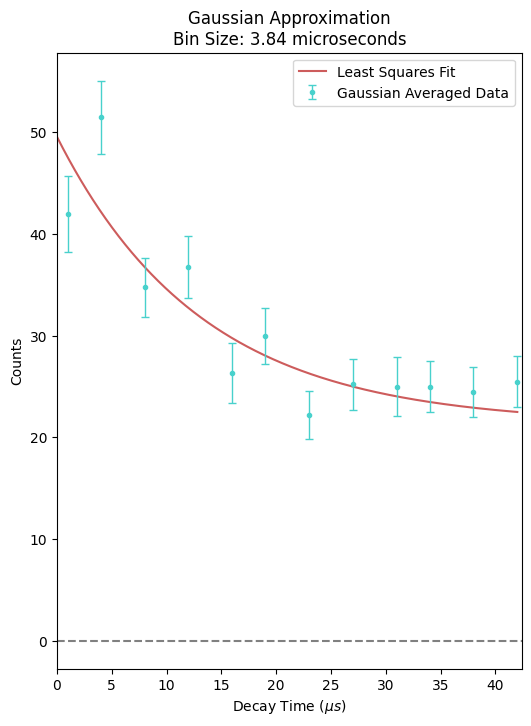

In [298]:
#gPars, g_cov = FindFitParameters((x,y), ExponentialCurve, sigma=rebinnedData[2])


fig, ax = plt.subplots(1, 1, figsize=(6,8))

fitCurveX = np.linspace(0, max(x), 1000)
ax.plot(fitCurveX, ExponentialCurve(fitCurveX, gPars[0], gPars[1], gPars[2], gPars[3]), color="indianred", label="Least Squares Fit")

#print(ExponentialCurve((1000, 4000), gPars[0], gPars[1], gPars[2], gPars[3]))

#ax.plot(fitCurveX, ExponentialCurve(fitCurveX, 18, -0.05, 0.1, 20), color="orange", label="Test Function")

ax.errorbar(x, y, yerr=yErr, fmt=".", capsize=3, linewidth=1, color="mediumturquoise", label="Gaussian Averaged Data")

ax.set_xlabel("Decay Time ($\mu s$)")
ax.set_ylabel("Counts")
ax.legend()
ax.set_title(f"Gaussian Approximation\nBin Size: {binSize:0.2f} microseconds")
ax.margins(x=0)
ax.hlines([0], 0, max(x) + 0.01*max(x), color="grey", ls="dashed")
#ax.set_yscale("log")

### Half-life estimation

In [301]:
# slope: ln(y) = ln(a)(b), ignoring d as it is small

slope = log(gPars[0])*gPars[1]

# decay constant for expression exp(-lamda)
decayConst = -slope

print((log(2) / decayConst))

3.653174952153504


In [40]:
decayConstant_ch = -1/gPars[1]

print(decayConstant_ch)

NameError: name 'gPars' is not defined

## Maximum Likelihood Estimation

In [37]:
#data = LoadExperimentRun("./../data/muons_T-800mV_W-40ns_DMH_75600s.txt", 90)

data = LoadMultipleRuns("../data/", "autoDetection_T-800mV_40ns_DMH_", (90, 20))

binFraction = 0.022
binSize = int(binFraction * data[0][-1])
print(f"Bin Size: {binSize} channels")

rebinnedData = RebinData(data, binFraction, method="MLE", verbose=False)

x = rebinnedData[0]
y = rebinnedData[1]
y = np.squeeze(y)

yErr = np.array(list(zip(rebinnedData[2], rebinnedData[3]))).T
yErr = np.squeeze(yErr)

Loading:
['../data/autoDetection_T-800mV_40ns_DMH_4320s_001.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_002.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_003.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_004.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_005.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_006.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_007.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_008.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_009.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_010.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_011.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_012.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_013.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_014.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_015.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_016.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_017.txt', '../data/autoDetection_T-800mV_40ns_DM

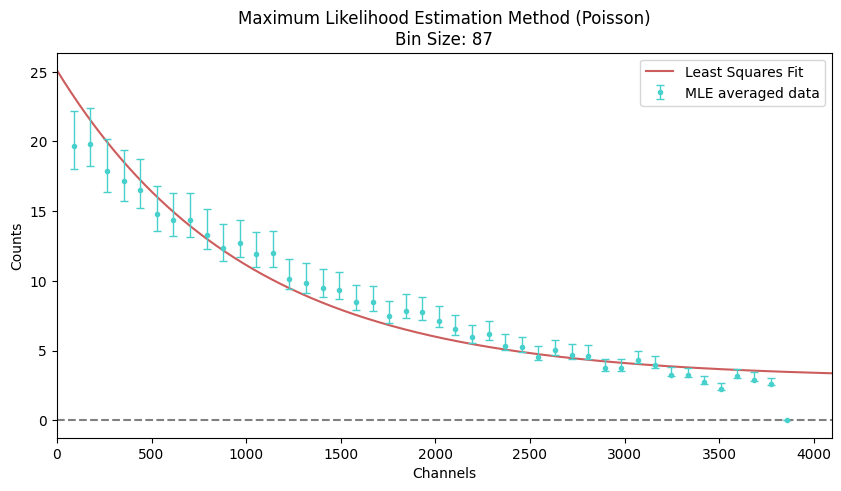

In [39]:
sig = []
for a, b in zip(np.squeeze(rebinnedData[2]), np.squeeze(rebinnedData[3])):
    sig.append(np.sqrt(a**2 + b**2))

pars, cov = FindFitParameters((x, y), ExponentialCurve, sigma=sig)


fig, ax = plt.subplots(1, 1, figsize=(10,5))

fitCurveX = np.linspace(0, 4096, 1000)
ax.plot(fitCurveX, ExponentialCurve(fitCurveX, pars[0], pars[1], pars[2], pars[3]), color="indianred", label="Least Squares Fit")

ax.errorbar(x, y, yerr=yErr, fmt=".", capsize=3, linewidth=1, color="mediumturquoise", label="MLE averaged data")
ax.set_xlabel("Channels")
ax.set_ylabel("Counts")
ax.legend()
ax.set_title(f"Maximum Likelihood Estimation Method (Poisson)\nBin Size: {binSize}")
ax.margins(x=0)
ax.hlines([0], 0, 4096, color="grey", ls="dashed")
#ax.set_yscale("log")